# **Problem Statement:**
Can you use Machine Learning to estimate, as precisely as possible, the uncertainty distribution of a household’s total monthly expenses?

**Dataset:**
The input features include consumer id, year, month, education level, age of the reference person, family size, urban residency, race, region of residency, state of residency, marital status, occupation, annual income (income), and consumer unit weight.
The consumer unit weight shows how much a row is representative of US population. The target variable is the monthly expense column.

Assume that occupation, marital status, state, region, race, urban are categorical variables, education is an ordinal variable.

Notice that multiple age, education, race, and income are individual features of the reference person in a potential household while total expenses is a household-level variable.


**Evaluation Metric** : Weighted Pinball Loss function


# **Data Exploration**
The first step involves carrying out some exploratory data analysis (EDA) to better understand the dataset. Our primary goal is to apply a Quantile Regression model to predict the 'expense' attribute.

Let's delve deeper into this data, highlighting insights that may have an impact on our quantile regression model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

train= pd.read_csv("/content/train.csv")
test= pd.read_csv("/content/test.csv")
print("train size:"+ str(train.shape))
print("test size:"+ str(test.shape))

train size:(741874, 15)
test size:(185469, 13)


In [2]:
print(test.columns)
print(train.columns)

Index(['id', 'year', 'month', 'age', 'education', 'familysize', 'urban',
       'race', 'region', 'state', 'marital', 'occupation', 'income'],
      dtype='object')
Index(['id', 'wi', 'year', 'month', 'age', 'education', 'familysize', 'urban',
       'race', 'region', 'state', 'marital', 'occupation', 'income',
       'expense'],
      dtype='object')


Check for missing values

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("Missing values in train data:\n", train.isnull().sum())
print("Missing values in test data:\n", test.isnull().sum())

Missing values in train data:
 id                 0
wi                 0
year               0
month              0
age                0
education          0
familysize         0
urban              0
race               0
region          6994
state          95742
marital            0
occupation    233483
income             0
expense            0
dtype: int64
Missing values in test data:
 id                0
year              0
month             0
age               0
education         0
familysize        0
urban             0
race              0
region         1826
state         24016
marital           0
occupation    58171
income            0
dtype: int64


In [116]:
# Display the summary statistics of the numerical variables
print("Summary Statistics of the Train Dataset:\n", train.describe())
print("Summary Statistics of the Test Dataset:\n", test.describe())

Summary Statistics of the Train Dataset:
                  id             wi           year          month  \
count  741874.00000  741874.000000  741874.000000  741874.000000   
mean   370937.50000    1742.251553    2009.074011       6.258592   
std    214160.72114     665.767268       4.528342       3.455627   
min         1.00000      46.000000    2002.000000       1.000000   
25%    185469.25000    1365.000000    2005.000000       3.000000   
50%    370937.50000    1643.000000    2009.000000       6.000000   
75%    556405.75000    2030.000000    2013.000000       9.000000   
max    741874.00000   16224.000000    2017.000000      12.000000   

                 age      education     familysize          urban  \
count  741874.000000  741874.000000  741874.000000  741874.000000   
mean       49.708089      13.233757       2.516659       1.065155   
std        17.362956       1.858918       1.501399       0.246800   
min        15.000000       0.000000       1.000000       1.000000   


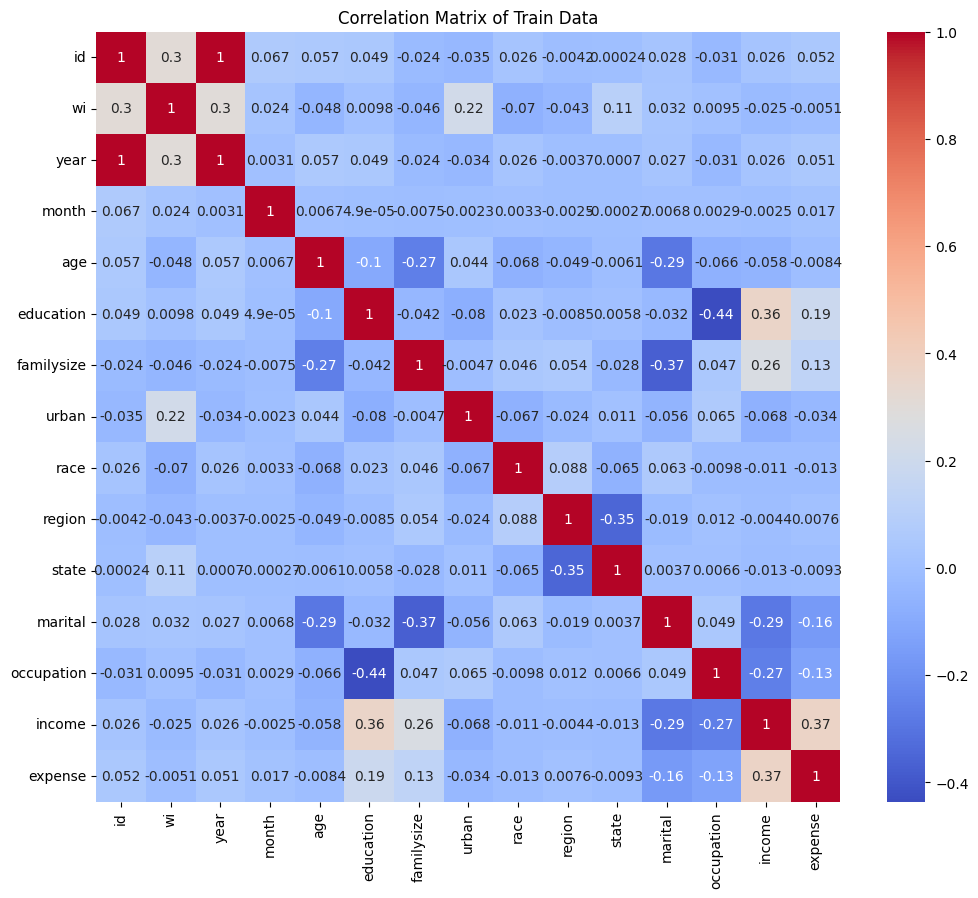

In [117]:
# Display the correlation matrix, to identify potential correlations between 'expense' and other variables
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Train Data")
plt.show()

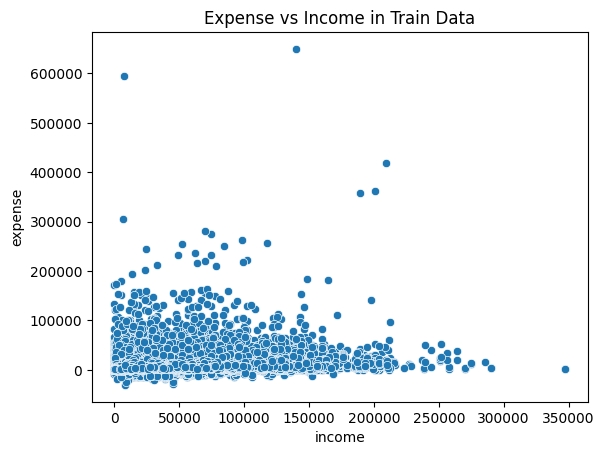

In [118]:
# Explore relationships between 'expense' and other features (for instance, 'income')
sns.scatterplot(data=train, x='income', y='expense')
plt.title("Expense vs Income in Train Data")
plt.show()

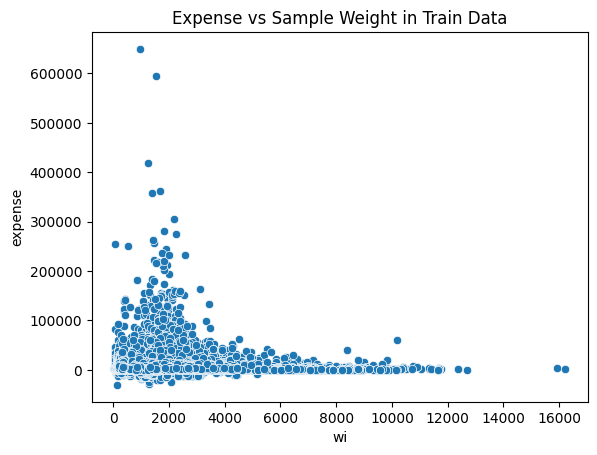

In [119]:
# let's visualize 'wi' relationship with 'expense'
sns.scatterplot(data=train, x='wi', y='expense')
plt.title("Expense vs Sample Weight in Train Data")
plt.show()

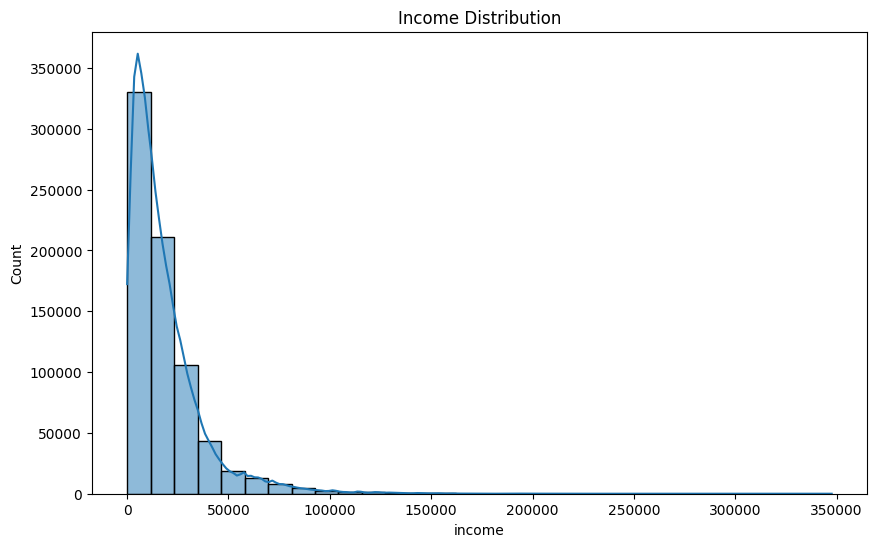

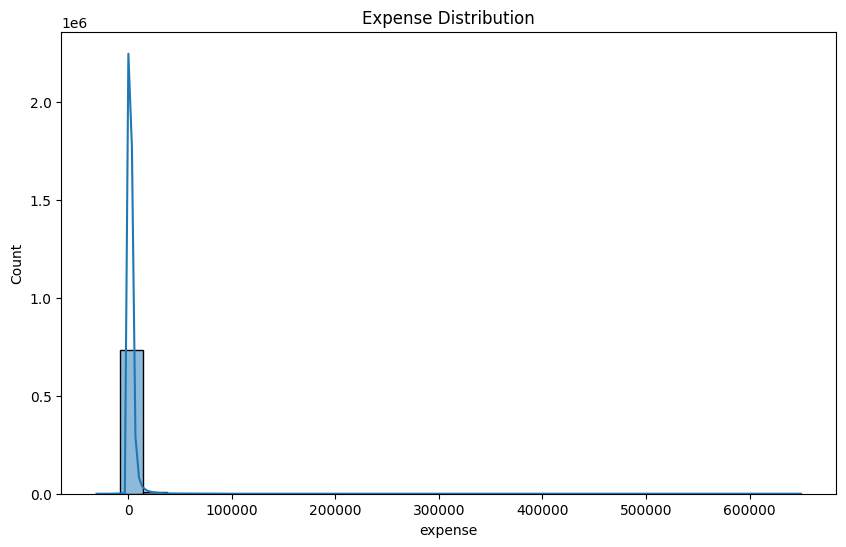

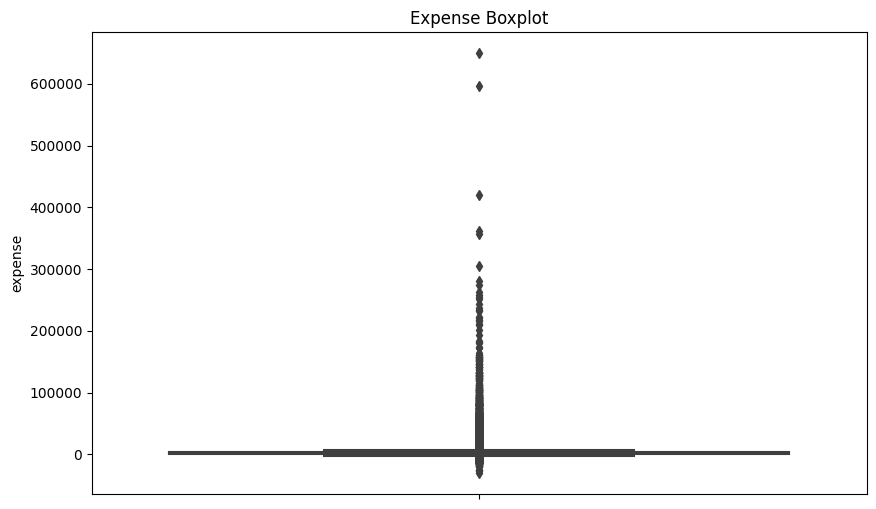

In [120]:
# Histogram for the 'income' variable
plt.figure(figsize=(10, 6))
sns.histplot(train['income'], bins=30, kde=True)
plt.title("Income Distribution")
plt.show()

# Histogram for the 'expense' variable
plt.figure(figsize=(10, 6))
sns.histplot(train['expense'], bins=30, kde=True)
plt.title("Expense Distribution")
plt.show()


# Boxplot for the 'expense' variable
plt.figure(figsize=(10, 6))
sns.boxplot(y='expense', data=train)
plt.title("Expense Boxplot")
plt.show()

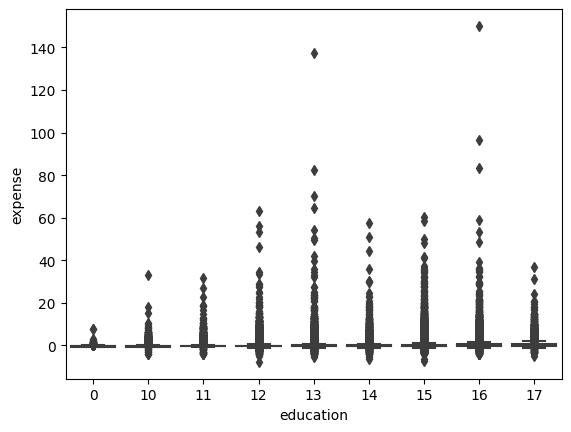

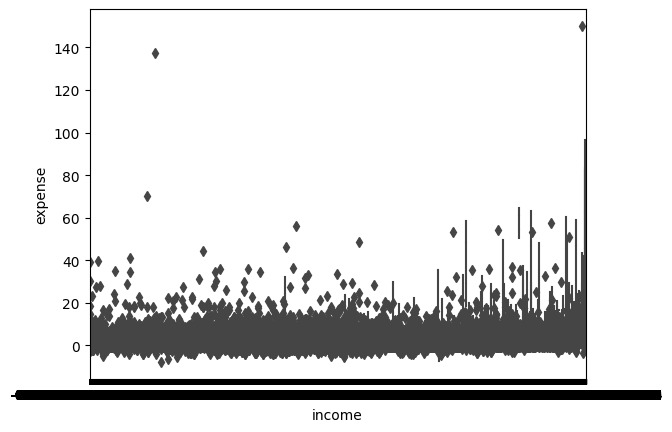

In [75]:
# Boxplot for 'monthly expense' across different 'education' levels
sns.boxplot(x='education', y='expense', data=train)
plt.show()

# Boxplot for 'monthly expense' across different 'education' levels
sns.boxplot(x='income', y='expense', data=train)
plt.show()


There is no missing data in the majority of our variables in both the training and testing sets. However, we have detected some missing data in 'region', 'state', and 'occupation' fields in both datasets. Our next steps should involve strategies for handling these missing values.

Based on the statistical summary of the train and test datasets:



*   The 'year' variable spans from 2002 to 2017, and the datasets seem to be evenly spread across this range.
*   The 'age' variable ranges from 15 to 87 years, with the majority of the instances lying between 36 and 62 years of age.
*   'Education' appears to range between 0 and 17, assuming these are ordinal categories signifying different levels of education.
*   The 'familysize' variable suggests that most families include 1 to 3 individuals.
*   'Urban' is a binary variable, with the majority of instances corresponding to category 1, which could indicate urban residency.
*   The 'race' variable is largely dominated by category 1, though the exact racial demographic this refers to is not specified in the data provided.
*   The variable 'region' ranges from 1 to 4, with most instances falling within regions 2 and 3.
*   The 'state' variable encompasses up to 55 unique states, with the majority of instances spread across states 12 to 42.
*   The 'marital' status feature ranges from 1 to 5, with most instances belonging to categories 1 and 3.
*   The 'occupation' feature has up to 18 unique categories, with most individuals engaging in occupations labeled 3 and 10.
*   'Income' exhibits a large variance with values from 0 up to around 350,000 in the training data and around 300,000 in the test data. It has a positively skewed distribution, as suggested by the substantial difference between the mean and the median.
*  'Expense' in the training data also shows a high degree of variability, with a minimum value indicating a significant loss (negative expense) and a maximum value of approximately 650,000. This variable is also positively skewed.




**Which variables are most strongly correlated with the target variable?**

In [5]:
# Display correlations between 'monthly expense' and all other variables
correlation = train.corr()['expense'].sort_values(ascending=False)
print(correlation)

expense       1.000000
income        0.368773
education     0.189339
familysize    0.134576
id            0.051661
year          0.051100
month         0.017014
region        0.007617
wi           -0.005056
age          -0.008418
state        -0.009319
race         -0.013151
urban        -0.034066
occupation   -0.130840
marital      -0.162814
Name: expense, dtype: float64


**How is the target variable distributed? Is it normally distributed or skewed?**

Using Shapiro-Wilk test to provide a more definitive measure of how likely it is that the data came from a normal distribution.

In [6]:
from scipy.stats import shapiro
stat, p = shapiro(train['expense'])
print(f'Statistics={stat}, p={p}')

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Statistics=0.407561719417572, p=0.0
Sample does not look Gaussian (reject H0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Based on the findings from the initial exploration, the next steps include:


1.   Handling missing data.
2.   Standardizing or normalizing certain variables.
3.   Checking for and treating potential outliers.



**1. Handling Missing Data**

Since 'region', 'state', and 'occupation' have missing values, for simplicty I'll replace the NaNs with the most common value (mode) in these columns. However, I can consider using more sophisticated methods like predictive imputation later.


In [7]:
# Handling missing data in train dataset
for col in ['region', 'state', 'occupation']:
    train[col].fillna(train[col].mode()[0], inplace=True)

# Handling missing data in test dataset
for col in ['region', 'state', 'occupation']:
    test[col].fillna(test[col].mode()[0], inplace=True)


**2. Standardizing Variables**

'Income' and 'expense' variables exhibit significant variances. We'll standardize these variables using the StandardScaler from sklearn to make them easier to handle by our model.

In [8]:
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Fit and transform the 'income' column in the train and test datasets
train['income'] = scaler.fit_transform(train[['income']])
test['income'] = scaler.transform(test[['income']])

# Fit and transform the 'expense' column in the train dataset
train['expense'] = scaler.fit_transform(train[['expense']])


In [ ]:
print("max:" + str(train['expense'].max()))
print("min:" + str(train['expense'].min()))

max:150.1111775979035
min:-7.74613828027111


**4. Handling Categorical and Ordinal Features**

Given the assumption that occupation, marital status, state, region, race, and urban are categorical variables, and education is an ordinal variable, we need to handle these differently.

For categorical variables, we can use one-hot encoding, and for the ordinal variable, we can keep it as is since it's already in a numerical format representing the order.

In [9]:
# import necessary libraries
from sklearn.preprocessing import OneHotEncoder

# list of categorical columns to one-hot encode
categorical_columns = ['occupation', 'marital', 'state', 'region', 'race', 'urban']

# instantiate the one-hot encoder
ohe = OneHotEncoder(drop='first', sparse=False)

# fit the encoder on the training data
ohe.fit(train[categorical_columns])

# transform the training data
train_encoded = ohe.transform(train[categorical_columns])
train_encoded = pd.DataFrame(train_encoded, columns=ohe.get_feature_names_out(categorical_columns))
train = pd.concat([train.drop(columns=categorical_columns), train_encoded], axis=1)

# transform the test data
test_encoded = ohe.transform(test[categorical_columns])
test_encoded = pd.DataFrame(test_encoded, columns=ohe.get_feature_names_out(categorical_columns))
test = pd.concat([test.drop(columns=categorical_columns), test_encoded], axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
print(test.shape)
print(train.shape)

(185469, 81)
(741874, 83)


**Quantiles Regression Problem**

**Loss function:**
The loss for an individual data point is defined as:
$$
\begin{align}
\mathcal{L}(\xi_i|\alpha)=\begin{cases}
\alpha \xi_i &\text{if }\xi_i\ge 0, \\
(\alpha-1) \xi_i &\text{if }\xi_i< 0.
\end{cases}
\end{align}
$$
where $\alpha$ is the required quantile and $\xi_i = y_i - f(\mathbf{x}_i)$ and, $f(\mathbf{x}_i)$ is the predicted (quantile) model.

The final overall loss is defines as:
$$\mathcal{L}(\mathbf{y},\mathbf{f}|\alpha)=\frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i-f(\mathbf{x}_i)|\alpha)$$

# **Approach1: Quantile regression model using statsmodels library**

We first define the features we're going to use in the model. Then, for each quantile, we train a quantile regression model and add it to our list of models. Once the models are trained, we can use them to make predictions for each quantile on the test data. The predictions are then saved to a DataFrame, which is finally saved to a CSV file.

In [13]:
%%time
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split

# Define features and target variable
train_x=train.drop(columns=['id','wi','expense'])
target = 'expense'

X = sm.add_constant(train_x)
y = train[target]
weights = train['wi']

# Quantiles that we're interested in
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

CPU times: user 581 ms, sys: 557 ms, total: 1.14 s
Wall time: 1.13 s


In [ ]:
# Train a quantile regression model for each quantile
models = []
for qt in quantiles:
    model = QuantReg(y, X)
    res = model.fit(q=qt, weights=weights)
    models.append(res)

After prediction, i used inverse scalar transform for the predicted values.

In [ ]:
import numpy as np

import statsmodels.api as sm
# Preprocess test data in the same way as training data
X_test = sm.add_constant(test.drop(columns=['id']))
predictions = pd.DataFrame()
predictions['id'] = test['id'].copy()

for i, model in enumerate(models):
    y_pred_standardized = model.predict(X_test)
    y_pred_standardized = y_pred_standardized.values.reshape(-1, 1)  # Convert to numpy array and reshape
    y_pred = scaler.inverse_transform(y_pred_standardized)
    predictions[f'q{i+1}'] = y_pred

# Save the predictions to a CSV file
predictions.to_csv('test_quantiles_quantile_reg.csv', index=False)


In [ ]:
predictions.head()

,id,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,741875,0.001040,-44.801135,204.546156,320.659986,551.860855,876.050836,1050.722357,2037.057549,4949.592413
1,741876,0.000499,-30.948986,1197.878390,1487.193651,2159.459998,3115.784745,3770.626267,8747.283096,17950.594454
2,741877,0.000563,-87.627266,238.359992,380.909139,642.105913,961.805642,1218.072112,3734.865995,10609.090932
3,741878,0.000719,18.963092,659.914881,856.295146,1399.882196,2222.233920,2749.677278,7071.388851,16374.911035
4,741879,0.000829,-60.284304,522.078274,695.435039,1051.885251,1525.240164,1802.228385,3966.679109,7375.876459


For the subsequent experiment, I plan to partition the data into training and validation sets and then re-run the experiment.

In [ ]:
%%time
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split

# Define features and target variable
train_x = train.drop(columns=['id', 'wi', 'expense'])
target = 'expense'

X = sm.add_constant(train_x)
y = train[target]
weights = train['wi']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Quantiles that we're interested in
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Define the weighted Pinball Loss function
def weighted_pinball_loss(y_true, y_pred, quantile, sample_weight=None):
    diff = y_true - y_pred
    weighted_diff = np.where(diff >= 0, quantile * diff, (quantile - 1) * diff)
    if sample_weight is not None:
        return np.average(weighted_diff, weights=sample_weight)
    else:
        return np.mean(weighted_diff)

# Train a quantile regression model for each quantile
models = []
train_losses = []
val_losses = []
for qt in quantiles:
    model = QuantReg(y_train, X_train)
    res = model.fit(q=qt, weights=weights_train)
    models.append(res)

    # Predict on training set
    train_preds = res.predict(X_train)
    train_loss = weighted_pinball_loss(y_train, train_preds, quantile=qt, sample_weight=weights_train)
    train_losses.append(train_loss)

    # Predict on validation set
    val_preds = res.predict(X_val)
    val_loss = weighted_pinball_loss(y_val, val_preds, quantile=qt, sample_weight=weights_val)
    val_losses.append(val_loss)

    print(f"Quantile: {qt}, Train Weighted Pinball Loss: {train_loss:.2f}, Validation Weighted Pinball Loss: {val_loss:.2f}")
# Now, 'models' contains the trained quantile regression models.
# 'train_losses' contains the weighted Pinball Loss for each quantile on the training set.
# 'val_losses' contains the weighted Pinball Loss for each quantile on the validation set.


Quantile: 0.005, Train Weighted Pinball Loss: 0.00, Validation Weighted Pinball Loss: 0.00
Quantile: 0.025, Train Weighted Pinball Loss: 0.02, Validation Weighted Pinball Loss: 0.02
Quantile: 0.165, Train Weighted Pinball Loss: 0.08, Validation Weighted Pinball Loss: 0.08
Quantile: 0.25, Train Weighted Pinball Loss: 0.11, Validation Weighted Pinball Loss: 0.11
Quantile: 0.5, Train Weighted Pinball Loss: 0.16, Validation Weighted Pinball Loss: 0.16
Quantile: 0.75, Train Weighted Pinball Loss: 0.17, Validation Weighted Pinball Loss: 0.17
Quantile: 0.835, Train Weighted Pinball Loss: 0.16, Validation Weighted Pinball Loss: 0.16
Quantile: 0.975, Train Weighted Pinball Loss: 0.08, Validation Weighted Pinball Loss: 0.08
Quantile: 0.995, Train Weighted Pinball Loss: 0.03, Validation Weighted Pinball Loss: 0.03
CPU times: user 4h 13min 7s, sys: 5h 24min 3s, total: 9h 37min 10s
Wall time: 16min 30s


In [ ]:
import numpy as np

# Preprocess test data in the same way as training data
X_test = sm.add_constant(test.drop(columns=['id']))
predictions = pd.DataFrame()
predictions['id'] = test['id'].copy()

for i, model in enumerate(models):
    y_pred_standardized = model.predict(X_test)
    y_pred_standardized = y_pred_standardized.values.reshape(-1, 1)  # Convert to numpy array and reshape
    y_pred = scaler.inverse_transform(y_pred_standardized)
    predictions[f'q{i+1}'] = y_pred

# Save the predictions to a CSV file
predictions.to_csv('test_quantiles_quantile_reg_with_validation.csv', index=False)

In [ ]:
predictions.head()

,id,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,741875,0.001100,-43.632620,203.813957,321.713383,552.443212,874.795699,1054.024277,2084.033044,5063.755808
1,741876,0.000567,-28.577585,1194.310739,1481.414983,2142.765835,3086.105891,3733.258953,8970.667276,18179.694118
2,741877,0.000586,-84.087576,240.417588,378.064125,637.561711,943.011758,1180.956195,3520.906043,10292.701194
3,741878,0.000626,15.815499,653.949367,849.798388,1393.015418,2228.000030,2727.703159,7060.043263,16288.639431
4,741879,0.000831,-61.929307,518.209546,697.513784,1063.840576,1524.402762,1817.651082,3995.056776,7281.497548


In general, quantile regression should not produce quantiles where a lower quantile value (e.g., q1) is greater than a higher quantile value (e.g., q2). There could be few factors that can lead to this unexpected result. Here are a few possible reasons:

**Model convergence:** The quantile regression models may not have converged properly, leading to inaccurate parameter estimates.

**Outliers or influential observations**: Extreme outliers or influential observations in the data can have a strong impact on the estimated quantiles.

**Data quality issues:** Inconsistent or erroneous data can lead to unexpected results.

**Sample size:**The accuracy of quantile estimates can be affected.

Given that the data is not small, and the dataset is robust, there could be problem with model convergence. Lets try other models.








# **Approach2:** **Gradient Boosting Regressor**

The GradientBoostingRegressor class in scikit-learn offers several parameters that can be tuned to adjust the behavior of the gradient boosting regression model. Here are some important parameters:

**loss:** The loss function to be optimized.
**alpha:** The quantile to be estimated.
**n_estimators:** The number of boosting stages (trees) to be used.
**learning_rate:** The learning rate shrinks the contribution of each tree. .
**max_depth:** The maximum depth of the individual regression estimators (trees).
**subsample:** The fraction of samples to be used for fitting each individual tree.

In [69]:
from sklearn.ensemble import GradientBoostingRegressor

# Create a GradientBoostingRegressor for each quantile and store in the models list
models = []
for qt in quantiles:
    model = GradientBoostingRegressor(loss='quantile', alpha=qt)
    model.fit(X, y, sample_weight=weights)
    models.append(model)

# Predict values for each model and store in the dataframe
train_preds = pd.DataFrame(index=X.index)
for i, model in enumerate(models):
    train_preds[f'q{i+1}'] = model.predict(X)

In [70]:
def weighted_pinball_loss(y_true, y_pred, weights, quantile):
    """
    Calculate the Weighted Pinball Loss for a given quantile.

    Arguments:
    y_true -- the true values
    y_pred -- the predicted values
    weights -- the weights for the data points
    quantile -- the quantile at which predictions were made
    """
    delta = y_true - y_pred
    loss = np.maximum(quantile * delta, (quantile - 1) * delta)
    return np.mean(loss * weights)

# Calculate and print Weighted Pinball Loss for each quantile
losses = []
for i, qt in enumerate(quantiles):
    loss = weighted_pinball_loss(y, train_preds[f'q{i+1}'], weights, qt)
    losses.append(loss)
    print(f'Quantile: {qt}, Weighted Pinball Loss: {loss}')

# Calculate and print total Weighted Pinball Loss
total_loss = np.mean(losses)
print(f'Total Weighted Pinball Loss: {total_loss}')

Quantile: 0.005, Weighted Pinball Loss: 8.35294726532132
Quantile: 0.025, Weighted Pinball Loss: 29.093712959565227
Quantile: 0.165, Weighted Pinball Loss: 139.7940450289495
Quantile: 0.25, Weighted Pinball Loss: 187.8927276215138
Quantile: 0.5, Weighted Pinball Loss: 281.28067030685224
Quantile: 0.75, Weighted Pinball Loss: 295.72014015894405
Quantile: 0.835, Weighted Pinball Loss: 271.75792976260954
Quantile: 0.975, Weighted Pinball Loss: 133.62476639682882
Quantile: 0.995, Weighted Pinball Loss: 58.19623922044845
Total Weighted Pinball Loss: 156.19035319122588


In [71]:
import pandas as pd
import numpy as np
# Create a dataframe to store the predictions for each model
predictions = pd.DataFrame()
predictions['id'] = test['id']

# Predict values for each model and store in the dataframe
for i, model in enumerate(models):
    y_pred = model.predict(X_test)
    y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))
    predictions[f'q{i+1}'] = y_pred_actual.flatten()

# Save the predictions to a CSV file
predictions.to_csv('test_quantiles_gardient_boosting.csv', index=False)

In [72]:
from google.colab import files
files.download("test_quantiles_gardient_boosting.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import  GridSearchCV

# Create a GradientBoostingRegressor for each quantile and store in the models list
models = []
for qt in quantiles:
    params = {'n_estimators': [100], 'max_depth': [4], 'min_samples_split': [5], 'learning_rate': [0.1], 'loss': ['quantile'], 'alpha': [qt]}
    regressor = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid=params, cv=3)
    regressor.fit(X, y, sample_weight=weights)
    models.append(regressor)

# Predict values for each model and store in the dataframe
train_preds = pd.DataFrame(index=X.index)
for i, model in enumerate(models):
    train_preds[f'q{i+1}'] = model.predict(X)

In [60]:
# Calculate and print Weighted Pinball Loss for each quantile
losses = []
for i, qt in enumerate(quantiles):
    loss = weighted_pinball_loss(y, train_preds[f'q{i+1}'], weights, qt)
    losses.append(loss)
    print(f'Quantile: {qt}, Weighted Pinball Loss: {loss}')

# Calculate and print total Weighted Pinball Loss
total_loss = np.mean(losses)
print(f'Total Weighted Pinball Loss: {total_loss}')

Quantile: 0.005, Weighted Pinball Loss: 8.198668341752265
Quantile: 0.025, Weighted Pinball Loss: 28.140886795385914
Quantile: 0.165, Weighted Pinball Loss: 138.97563162466216
Quantile: 0.25, Weighted Pinball Loss: 187.1126545543143
Quantile: 0.5, Weighted Pinball Loss: 280.20931972441565
Quantile: 0.75, Weighted Pinball Loss: 294.20544449184166
Quantile: 0.835, Weighted Pinball Loss: 270.4125793482839
Quantile: 0.975, Weighted Pinball Loss: 132.50501255179492
Quantile: 0.995, Weighted Pinball Loss: 57.09825232086651
Total Weighted Pinball Loss: 155.20649441703526


In [66]:
X_test = sm.add_constant(test.drop(columns=['id']))
import pandas as pd
import numpy as np
# Create a dataframe to store the predictions for each model
predictions = pd.DataFrame()
predictions['id'] = test['id']

# Predict values for each model and store in the dataframe
for i, model in enumerate(models):
    y_pred = model.predict(X_test)
    y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))
    predictions[f'q{i+1}'] = y_pred_actual.flatten()

# Save the predictions to a CSV file
predictions.to_csv('test_quantiles_gardient_boosting_gridsearch.csv', index=False)

In [67]:
from google.colab import files
files.download("test_quantiles_gardient_boosting_gridsearch.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Approach3: Deep Learning-based Approach**


Step 1: Define the Quantile Loss Function

Define a custom loss function for the model. This loss function will calculate the quantile loss for the given quantiles

In [39]:
import tensorflow as tf

def quantile_loss(q, y_true, y_pred):
    e = y_true - y_pred
    return tf.keras.backend.mean(tf.maximum(q*e, (q-1)*e), axis=-1)


In [38]:
def weighted_pinball_loss(quantile,y_true, y_pred, weights):
    """
    Calculate the Weighted Pinball Loss for a given quantile.

    Arguments:
    y_true -- the true values
    y_pred -- the predicted values
    weights -- the weights for the data points
    quantile -- the quantile at which predictions were made
    """
    delta = y_true - y_pred
    loss = np.maximum(quantile * delta, (quantile - 1) * delta)
    return np.mean(loss * weights)

Step 2: Build the Model

Use a sequential model with several layers:

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model():
    model = Sequential([
        Dense(128, activation='relu', input_dim=X_train.shape[1]),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(9)  # We have 9 quantiles to predict
    ])
    return model


Step 4: Train the Model for Each Quantile

Now, compile and train the model for each of the required quantiles:

In [28]:
X_train = train.drop(columns=['id', 'wi', 'expense'])
target = 'expense'
y_train = train['expense']
weights_train = train['wi']
X_test = test.drop(columns=['id'])

In [ ]:
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Prepare the predictions dataframe
predictions = pd.DataFrame(test['id'])

for i, q in enumerate(quantiles):
    print(f"Training for quantile {q}")

    model = build_model()
    model.compile(loss=lambda y_true, y_pred: quantile_loss(q, y_true, y_pred), optimizer='adam')
    model.fit(X_train, y_train, sample_weight=weights_train, epochs=3, batch_size=32, validation_split=0.1)

    # Make and store predictions
    pred_q = model.predict(X_test)
    predictions[f'q{i+1}'] = scaler.inverse_transform(pred_q[:, i].reshape(-1, 1)).flatten()

# Save the predictions
predictions.to_csv('test_quantiles_deep.csv', index=False)

In [41]:
predictions.head()

,id,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,741875,-1.384539,4.238019,81.765610,1149.501343,1947.783813,3338.27417,4125.61377,3945.496826,8656.571289
1,741876,-1.384539,4.238019,1128.408691,1149.501343,1947.783813,3338.27417,4125.61377,5355.386230,15450.846680
2,741877,-1.384539,4.238019,35.390850,1149.501343,1947.783813,3338.27417,4125.61377,4280.768555,11226.773438
3,741878,-1.384539,4.238019,599.754883,1149.501343,1947.783813,3338.27417,4125.61377,5350.181152,17202.601562
4,741879,-1.384539,4.238019,274.901337,1149.501343,1947.783813,3338.27417,4125.61377,4371.348145,11492.701172


In [42]:
from google.colab import files
files.download("test_quantiles_deep.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

To enhance the efficiency of the code, I aim to revise the training process so that all quantiles can learn concurrently. This can be achieved by adjusting the model to yield as many predictions as the number of quantiles I possess, and tailoring the bespoke loss function to calculate the quantile loss for each outcome. Here's the updated model:

Step 1: Refine the Quantile Loss Function

Let's devise a quantile loss function that can simultaneously handle multiple quantiles.

In [43]:
import tensorflow as tf

def multi_quantile_loss(y_true, y_pred):
    quantiles = tf.constant([0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995])
    e = y_true - y_pred
    v = tf.maximum(quantiles * e, (quantiles-1) * e)
    return tf.reduce_mean(v, axis=-1)

Step 2: Modify the Model Architecture
I need to output as many values as there are quantiles, so the last layer should have 9 neurons.

In [ ]:
# train_x = train.drop(columns=['id', 'wi', 'expense'])
# target = 'expense'

# X = train_x
# y = train[target]
# weights = train['wi']

X_train = train.drop(columns=['id', 'wi', 'expense'])
y_train = train['expense']
weights_train = train['wi']
X_test = test.drop(columns=['id'])

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_model():
    model = Sequential([
        Dense(128, activation='relu', input_dim=X_train.shape[1]),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(len(quantiles))  # We have 9 quantiles to predict
    ])
    return model


Step 3: Train the Model
Finally, compile and fit the model with the new multi-quantile loss:

In [ ]:
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]
model = build_model()

model.compile(loss=multi_quantile_loss, optimizer='adam')
model.fit(X_train, np.repeat(y_train.values[:, np.newaxis], len(quantiles), axis=1),
          sample_weight=weights_train, epochs=10, batch_size=32, validation_split=0.1)

This model will output 9 values for each input example, each one corresponding to a quantile prediction.

Step 4: Make Predictions

We will now use this model to make predictions on the test set:

In [46]:
# Prepare the predictions dataframe
predictions = pd.DataFrame(test['id'])

# Make and store predictions
preds = model.predict(test.drop(columns=['id']))

for i in range(len(quantiles)):
    predictions[f'q{i+1}'] = scaler.inverse_transform(preds[:, i].reshape(-1, 1)).flatten()

# Save the predictions
predictions.to_csv('test_quantiles_deep_simultaneous2.csv', index=False)


5796/5796 [==============================] - 6s 1ms/step


In [47]:
predictions.head()

,id,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,741875,-12.667986,32.575176,276.779510,374.373505,649.523193,1008.164429,1283.926025,3002.482910,7203.711914
1,741876,-1.400652,8.246809,1349.705078,1633.275635,2226.911621,3179.037598,3748.308594,8054.587402,18833.769531
2,741877,-2.914080,23.808332,479.283905,603.560547,910.456909,1389.121826,1694.716187,3583.371582,8710.268555
3,741878,-0.997820,13.768538,997.388428,1214.969116,1689.558838,2449.155029,2909.734863,6188.397461,14615.370117
4,741879,-0.629900,18.812971,675.498779,832.788574,1198.613281,1782.307373,2143.582764,4483.376953,10761.283203


In [ ]:
predictions.head()

,id,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,741875,-8.028093,60.373760,313.719452,405.256561,624.270020,925.366333,1146.326660,2731.539307,7644.960938
1,741876,6.242414,13.421858,1266.439209,1535.259521,2185.485107,3100.982910,3637.899658,7919.957031,17861.041016
2,741877,-7.446795,58.401592,345.632538,443.227264,676.555420,997.536987,1228.836060,2898.316895,7973.282227
3,741878,2.647687,24.166975,899.621704,1102.375122,1584.195557,2250.374756,2661.145264,5793.466309,13672.725586
4,741879,-3.204119,44.013165,578.467041,720.258545,1058.024780,1524.088623,1830.817139,4115.110840,10368.684570


In [48]:
from google.colab import files
files.download("test_quantiles_deep_simultaneous.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This model treats the problem as a multi-output regression task, where the network simultaneously predicts all the quantiles.

## **Approach4: Variational Auto Encoder for Quantile Regression**

A Variational Autoencoder (VAE) is a type of generative model that can learn the distribution of a given dataset. Here, it's suggested to use the VAE to learn the distribution of expenses, which can then be used to extract the quantiles of interest.
The Variational Autoencoder (VAE) can indeed be adapted to solve this task. Instead of generating new data as in the traditional use of VAEs, we will use the latent space of the VAE to predict the different quantiles of the target distribution.

In the setup we will use, the encoder part of the VAE will learn a meaningful representation of the input data in the latent space, and the decoder will be tasked to predict the quantiles from this latent representation.

Here's a summary of how the modified VAE is set up:

The encoder part of the VAE takes in the input features and maps them to a lower-dimensional latent space. This part is trained to learn a meaningful representation of data.
The decoder part, instead of reconstructing the original input as in a traditional VAE, is tasked to predict the quantiles from the learned representation (latent variables).
During training, the custom loss function combines the quantile loss (that calculates the deviation of the predicted quantiles from the true ones) and the Kullback-Leibler (KL) divergence (that forces the distribution of the latent variables to approximate a standard normal distribution).
In other words, the power of the VAE architecture is still being leveraged, but in a manner that is tailored to the specific needs of this problem: quantile regression with weighted samples.

In [49]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [50]:
X_train= train.drop(columns=['id', 'wi', 'expense'])
y_train= train['expense']
weights = train['wi']
X_test= test.drop(columns=['id'])

Next, we will define the architecture for the Variational Autoencoder:

In [51]:
# Define the structure of the VAE
original_dim = X_train.shape[1]  # Number of features
intermediate_dim = 64  # Number of neurons in the hidden layer
latent_dim = 2  # Dimension of the latent space

# Define the encoder part
inputs = Input(shape=(original_dim,), name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Define the decoder part
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)

# Predict the different quantiles from the latent space
outputs = [Dense(1)(x) for _ in range(len(quantiles))]

# Instantiate the VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')



We will now define a custom loss function that combines the quantile loss for the different quantiles and the Kullback-Leibler (KL) divergence for the VAE, then compile the model:



In [52]:
def weighted_quantile_loss(q, y_true, y_pred, sample_weight):
    e = y_true - y_pred
    return K.mean(sample_weight * K.maximum(q*e, (q-1)*e), axis=-1)

# Modify this part in the model compilation
reconstruction_loss = sum(weighted_quantile_loss(q, y_true, y_pred, sample_weight) for q, y_true, y_pred, sample_weight in zip(quantiles, y_train, outputs, weights))

# Rest of the model compilation and training remains the same
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam())

# vae.fit(X_train, epochs=10, batch_size=32)
vae.fit(X_train,y_train, epochs=5, batch_size=32, sample_weight=weights)

Epoch 1/5
23184/23184 [==============================] - 59s 2ms/step - loss: 111653715968.0000
Epoch 2/5
23184/23184 [==============================] - 55s 2ms/step - loss: 53.1857
Epoch 3/5
23184/23184 [==============================] - 55s 2ms/step - loss: 25.2925
Epoch 4/5
23184/23184 [==============================] - 56s 2ms/step - loss: 11.3473
Epoch 5/5
23184/23184 [==============================] - 55s 2ms/step - loss: 5.4309


In [55]:
# Make predictions
predictions = vae.predict(X_test)


5796/5796 [==============================] - 10s 2ms/step


In [ ]:
# Prepare the predictions dataframe
predictions_df = pd.DataFrame(test['id'])
for i, q in enumerate(quantiles):
    predictions_df[f'q{i+1}'] = scaler.inverse_transform(predictions[i]).flatten()
    # scaler.inverse_transform(preds[:, i].reshape(-1, 1)).flatten()
# Save the predictions
predictions_df.to_csv('test_quantiles_VAE_weighted.csv', index=False)

In this code, vae.predict(X_test) will return a list of arrays, where each array is the prediction for a specific quantile. This is because when the VAE was defined, the output was a list of layers, one for each quantile.
Then, for each quantile, we add the corresponding predictions to the predictions_df dataframe. The predictions are flattened to ensure they have the correct shape. Finally, the predictions are saved to a csv file.

In [ ]:
from google.colab import files
files.download("test_quantiles_VAE_weighted.csv")

# **Conclusion**
The entire process of this project, from a rudimentary method yielding less than satisfactory outcomes to a more intricate approach, has been detailed in this document. The journey can be broadly segmented into the following steps:

1.   Exploratory Analysis:
      *   Analysing Data Metrics
      *   Analysing target variable distribution
      *   Analysis of Feature Interrelations

2.   Preprocessing Data:
      *   Handling missing values
      *   Standardizing Variables
      *   Handling Categorical and Ordinal Features

3.   Quantile Regression:
      *   Approach1: Quantile Regression via Statsmodels Library
      *   Approach2: Gradient Boosting Regressor
      *   Approach3: Deep-learning based approach
      *   Approach4: Variational Autoencoders

The results are separately attached.

**Discussion1:** A statement in the problem definition draws my attention:

 ***Notice that multiple age, education, race, and income are individual features of the reference person in a potential household while total expenses is a household-level variable***

This suggests that the dataset may contain multiple rows for a single household, with each row representing a different individual in the household. A common way to handle this type of data is to aggregate individual-level data to the household level. Then we can compute the sum, mean, or other statistics of individual-level variables grouped by the household ID to get household-level features. For example, calculating the mean income and age per household. However, since the the customer id were unique, I was not sure what are the indicators of same family (wi?).


In [ ]:
# Assume 'id' is the household identifier
df_household = train.groupby('id').agg({
    'age': ['mean', 'max', 'min'],
    'education': ['mean', 'max', 'min'],
    'income': ['mean', 'sum'],
    'familysize': 'first',
    'urban': 'first',
    'region': 'first',
    'state': 'first',
    'monthly expense': 'first'
}).reset_index()

**Discussion2:** in traditional Variational Autoencoder (VAE), the network is trained to reconstruct its input data, hence the input and output are indeed the same during training. There are other ways to solve regression using VAE with the same architecture.
1.   One way is to joint regularization between the VAE and a neural-network regressor. Inference of model parameters leads to a combination between a traditional VAE network that models latent representations of data, and a regressor network that aims to predict expense. [Source](https://arxiv.org/abs/1904.05948)
2.   There is alo another approach called Deep Quantile Regression for Uncertainty Estimation. [Source](https://arxiv.org/abs/2109.09374)

Unfortunately, due to time constraints, I was unable to implement these approaches in the context of this specific problem.

**Discussion3:** With regard to the deep learning-oriented method, I utilized a sequential dense architecture employing the 'relu' activation function Initially, I trained a model for each individual quantile. However, in a subsequent attempt to increase efficiency, I modified the architecture to facilitate simultaneous learning of all quantiles.  To discover the optimal configuration for NN'based approached (same for VAE) further experimentation is required.

**Discussion4:** In quantile regression, outliers can have a significant impact on the estimation of quantiles. Applying appropriate techniques to handle outliers can improve the robustness and accuracy of our quantile regression model.